In [1]:
#%%################################ IMPORT MODULES ############################
import numpy as np
import pandas as pd
import re
import datetime
import os
import matplotlib.pyplot as plt

In [2]:
#%%################################ GRAB DATA ############################
#Think about adding module to get data straight from NWQMC website

In [3]:
#%%################################ SET SOURCE AND OUTPUT DIRECTORIES ############################
source_directory = "../data"
output_directory = "../data/scores"

In [4]:
#%%################################ IMPORT DATA ############################

data = pd.read_csv(os.path.join(source_directory, "narrowresult.csv"), encoding='latin1', low_memory=False)
station_data = pd.read_csv(os.path.join(source_directory, "Knox_County_Station_Info.csv"), encoding='latin1', low_memory=False)

In [5]:
#%%################################ CLEAN DATASET ############################

desired_columns = ['CharacteristicName', 'ActivityStartDate', 'MonitoringLocationIdentifier', \
                   'ResultDetectionConditionText', 'ResultMeasureValue', 'ResultMeasure/MeasureUnitCode', 'ProviderName']
data = data[desired_columns]
num_lost_from_na = len(data)
data = data.dropna(subset=['ResultMeasureValue'],inplace=False)
num_lost_from_na = num_lost_from_na - len(data)
print('Number of data points lost from NaN in whole dataset: {}'.format(num_lost_from_na))

Number of data points lost from NaN in whole dataset: 12560


In [6]:
#%%################################ ASSIGN LAT & LON ############################
station_columns = ['MonitoringLocationIdentifier', 'LatitudeMeasure', 'LongitudeMeasure']
station_data = station_data[station_columns]
data['Latitude'] = data['MonitoringLocationIdentifier'].map(station_data.set_index('MonitoringLocationIdentifier')['LatitudeMeasure'])
data['Longitude'] = data['MonitoringLocationIdentifier'].map(station_data.set_index('MonitoringLocationIdentifier')['LongitudeMeasure'])

In [7]:
#%%################################ DEFINE FUNCTIONS ############################

#Input a dataframe column and get back a cleaned list of values
#Removes nondecimal values, like Satisfactory, and removes strings from decimal values
#May be errors when numerics and characters are combined e.g. 300 CFU/100ml = 300100
def clean_values(row):
    value = row['ResultMeasureValue']
    try:
        return float(value)
    except ValueError:
        nondecimal = re.compile(r'[^\d.]+')
        clean_value = nondecimal.sub('', str(value))
        if clean_value == '':
            clean_value = np.nan
        else:
            clean_value = float(clean_value)
    return clean_value

#Converts date to datetime, checking for instances of double digit years, e.g. 1/1/97 = 1997, not 2097
def clean_date(row):
    date = row['ActivityStartDate']
    if date.year > (datetime.datetime.now().year + 1):
        year = date.year - 100
        day = date.day
        month = date.month
        clean_date = datetime.date(year, month, day)
    else:
        clean_date = date
    return clean_date

#Returns the score of a measurement on a line between two values
#High Score is the value that is given a 1, Low Score is the value that is given a 0
#This accounts for positive (/) and negative slopes (\)
def linear_score(high_score, low_score, measurement):
    score = 0.00
    rng = abs(high_score - low_score)
    slope = 1 / rng
    if high_score < low_score:
        score = 1 - slope * (measurement - high_score)
    else:
        score = slope * (measurement - low_score)
    return score

#Receives a dataframe and returns a dataframe with predefined measurement boundaries
def remove_outliers(df, metric):
    new_df = df
    if metric == 'pH':
        new_df = df[(df['ResultMeasureValue_Clean'] <= 14) & (df['ResultMeasureValue_Clean'] >= 0)]
    elif metric == 'Fecal Coliform':
        new_df = df[(df['ResultMeasureValue_Clean'] <= 30000) & (df['ResultMeasureValue_Clean'] >= 0)]

    return new_df

#Receives a dataframe and returns a dataframe with only measurements after a predefined date
def remove_old_measurements(df, metric):
    new_df = df[df.ActivityStartDate > datetime.datetime.strptime('12/31/09', '%m/%d/%y')]
    return new_df

#Fuzzy Scoring
#Gives a 1 to measurements in compliance and a 0 to measurements out of compliance
#Generates a linear score for measurements close to compliance
#Also accounts for unit conversion
#Use the apply function to calculate a score for each row in a dataframe
def fuzzy_scoring(row):
    measurement = row['ResultMeasureValue_Clean']
    unit = row['ResultMeasure/MeasureUnitCode_Clean']
    score = 0.00
    if metric == 'Dissolved Oxygen':
        if measurement < 5:
            score = 0.00
        elif measurement > 8:
            score = 1.00
        else:
            score = linear_score(8.00, 5.00, measurement)   
                
    if metric == 'pH':
        if measurement < 6:
            score = 0.00
        elif measurement < 7:
            score = linear_score(7.00, 6.00, measurement)
        elif measurement < 8:
            score = 1.00
        elif measurement < 9:
            score = linear_score(8.00, 9.00, measurement)
        else:
            score = 0.00
            
    if metric == 'Water Temperature':
        if measurement < 20.00:
            score = 1.00
        elif measurement < 30.50:
            score = linear_score(20.00, 30.50, measurement)
        else:
            score = 0.00     
    
    if metric == 'Total Dissolved Solids':
        #convert units
        if unit == 'tons/ac ft':
             measurement = measurement * 735.468
        #calculate score
        if measurement < 500.00:
            score = 1.00
        elif measurement < 600.00:
            score = linear_score(500, 600, measurement)
        else:
            score = 0.00
            
    if metric == 'Fecal Coliform':
        if measurement < 126.00:
            score = 1.00
        elif measurement < 630.00:
            score = linear_score(126.00, 630.00, measurement)
        else:
            score = 0.00

    if metric == 'E Coli':
        if measurement < 126.00:
            score = 1.00
        elif measurement < 630.00:
            score = linear_score(126.00, 630.00, measurement)
        else:
            score = 0.00

    if metric == 'Turbidity':
        if measurement < 25.00:
            score = 1.00
        elif measurement < 50.00:
            score = linear_score(25.00, 50.00, measurement)
        else:
            score = 0.00
    
    if metric == 'Kjeldahl Nitrogen':
        if unit == 'ug/l':
            measurement = measurement * .001
        
        if measurement < 1.00:
            score = 1.00
        elif measurement < 2.00:
            score = linear_score(1.00, 2.00, measurement)
        else:
            score = 0.00
    
    if metric == 'Phosphorus':
        if measurement < 0.05:
            score = 1.00
        elif measurement < 0.10:
            score = linear_score(0.05, 0.10, measurement)
        else:
            score = 0.00
        
    

            
    
    return score


In [8]:
#%%################################ CLEAN DATA ############################

#Clean Units of Trailing Whitespace
data['ResultMeasure/MeasureUnitCode_Clean'] = data['ResultMeasure/MeasureUnitCode'].str.strip()

#Clean the date using the clean_date function
data['ActivityStartDate'] = pd.to_datetime(data['ActivityStartDate'])    
data['ActivityStartDate_Clean'] = data.apply(clean_date, axis=1)

#Clean the values of strings using the clean_values function
data['ResultMeasureValue_Clean'] = data.apply(clean_values, axis=1)


In [9]:
#### Select Metric and Determine Aliases and Units ####
aliases = {'Dissolved Oxygen':['Dissolved oxygen (DO)', 'Oxygen'], \
          'pH':['pH'], \
          'Water Temperature': ['Temperature, water'], \
          'Total Dissolved Solids': ['Total dissolved solids'], \
          'Fecal Coliform': ['Fecal Coliform'], \
          'E Coli': ['Escherichia', 'Escherichia coli'], \
          'Turbidity': ['Turbidity'], \
          'Kjeldahl Nitrogen': ['Kjeldahl nitrogen'], \
          'Phosphorus': ['Phosphorus']}

units = {'Dissolved Oxygen': ['mg/l'], \
        'pH':['std units', 'None'], \
        'Water Temperature':['deg C'], \
        'Total Dissolved Solids': ['mg/l', 'tons/ac ft'], 
        'Fecal Coliform': ['cfu/100ml', '#/100ml', 'CFU'], \
        'E Coli': ['cfu/100ml', '#/100ml', 'CFU', 'MPN/100ml'], \
        'Turbidity': ['NTU'], \
        'Kjeldahl Nitrogen': ['mg/l', 'ug/l'], 
        'Phosphorus': ['mg/l']}

Dissolved Oxygen
Units: ['mg/l']
Number of data points lost from unit selection: 80
Number of data points lost from value cleaning: 0
Number of data points lost from outlier cleaning: 0
63 sites have reported values
490 data points recorded
31 sites reported values in 2018
104 data points reported in 2018
0.9042721088435374 is the average score

pH
Units: ['std units' 'None']
Number of data points lost from unit selection: 0
Number of data points lost from value cleaning: 0
Number of data points lost from outlier cleaning: 1
69 sites have reported values
522 data points recorded
31 sites reported values in 2018
104 data points reported in 2018
0.918735632183908 is the average score

Water Temperature
Units: ['deg C']
Number of data points lost from unit selection: 0
Number of data points lost from value cleaning: 0
Number of data points lost from outlier cleaning: 0
69 sites have reported values
517 data points recorded
31 sites reported values in 2018
104 data points reported in 2018


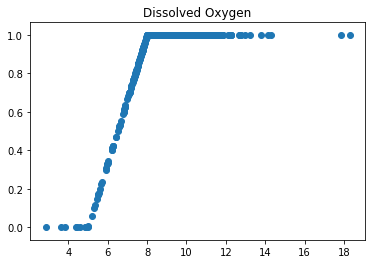

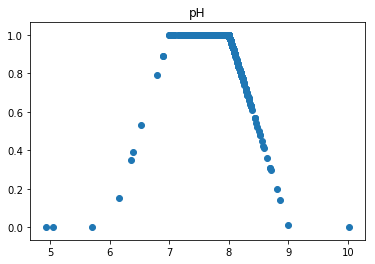

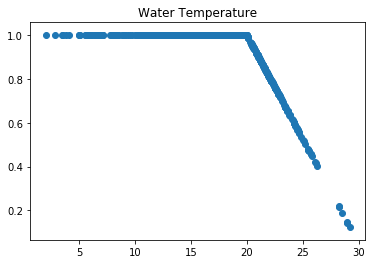

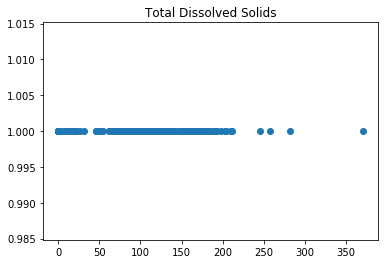

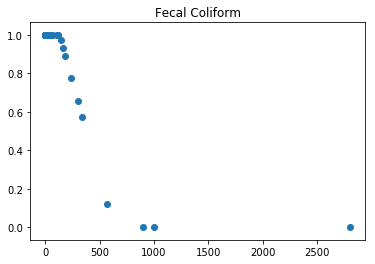

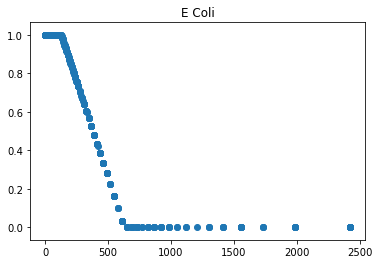

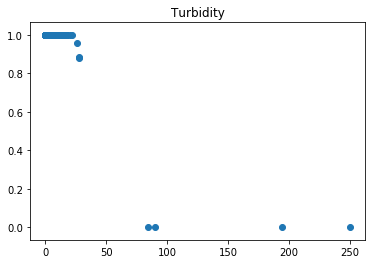

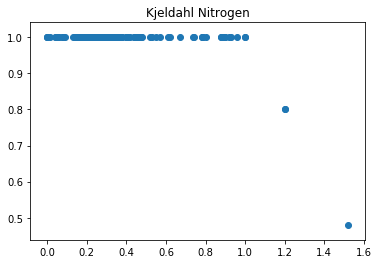

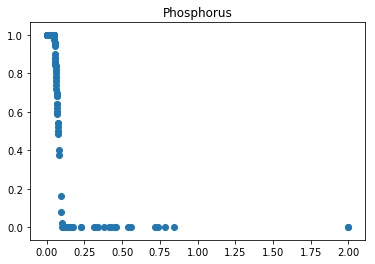

<Figure size 432x288 with 0 Axes>

In [10]:
#### Get Desired Values and Print Metric List ####

metrics = ['Dissolved Oxygen', 'pH', 'Water Temperature', 'Total Dissolved Solids', 'Fecal Coliform', 'E Coli', 'Turbidity', 'Kjeldahl Nitrogen', 'Phosphorus']
#metrics = ['Dissolved Oxygen']

#Phosphorus, Nitrogen, Turbidity (NTU)
#Visualize scores over time for each site
#Unit conversion via online tool
#Scrape NWQMC dataset

for metric in metrics:
    
    #%%################################ FILTER AND SCORE ############################
    
    #### Grab metrics by alias ####
    metric_temp_df = data[data['CharacteristicName'].isin(aliases[metric])]
    
    
    #### Clean NaN Values ####
    nan_clean1 = len(metric_temp_df['ResultMeasureValue_Clean'])
    metric_temp_df = metric_temp_df.dropna(subset=['ResultMeasureValue_Clean'])
    nan_clean2 = len(metric_temp_df['ResultMeasureValue_Clean'])
    
    #### Grab values with select units ####
    unit_clean1 = len(metric_temp_df['ResultMeasureValue_Clean'])
    metric_temp_df = metric_temp_df[metric_temp_df['ResultMeasure/MeasureUnitCode_Clean'].isin(units[metric])]
    unit_clean2 = len(metric_temp_df['ResultMeasureValue_Clean'])
    
    #### Clean Outliers ####
    outlier_clean1 = len(metric_temp_df['ResultMeasureValue_Clean'])
    metric_temp_df = remove_outliers(metric_temp_df, metric)
    outlier_clean2 = len(metric_temp_df['ResultMeasureValue_Clean'])
    
    #### Remove old measurements ####
    metric_temp_df = remove_old_measurements(metric_temp_df, metric)
    
    #### Get fuzzy Scoring ####
    metric_temp_df['Fuzzy Score'] = metric_temp_df.apply(fuzzy_scoring, axis=1)
    
    #### Plot fuzzy scores ####
    plt.scatter(metric_temp_df['ResultMeasureValue_Clean'], metric_temp_df['Fuzzy Score'])
    plt.title('{}'.format(metric))
    plt.figure()
    
    #%%################################ SUMMARIZE DATA QUALITY ############################
    
    #### Create a mask for the last year ####
    previous_year = datetime.datetime.now().year - 1
    starttime = datetime.datetime(previous_year, 1, 1)
    endtime = datetime.datetime(previous_year, 12, 31)
    mask = (metric_temp_df['ActivityStartDate_Clean'] > starttime) & (metric_temp_df['ActivityStartDate_Clean'] < endtime)
    
    #### Calculate Report Values ####
    sites = metric_temp_df.MonitoringLocationIdentifier.unique()
    num_sites = len(sites)
    num_sites_recent_year = len(metric_temp_df.loc[mask].MonitoringLocationIdentifier.unique())
    
    num_points = len(metric_temp_df['ResultMeasureValue_Clean'])
    num_points_recent_year = len(metric_temp_df.loc[mask]['ResultMeasureValue_Clean'])
    
    ave_score = metric_temp_df['Fuzzy Score'].mean()
    unit_list = metric_temp_df['ResultMeasure/MeasureUnitCode_Clean'].unique()
    
    num_lost_from_unit_selection = unit_clean1 - unit_clean2
    num_lost_from_value_clean = nan_clean1 - nan_clean2
    num_lost_from_outlier_clean = outlier_clean1 - outlier_clean2
    
    #### Print Report ####
    print('{}'.format(metric))
    print('Units: {}'.format(unit_list))
    print('Number of data points lost from unit selection: {}'.format(num_lost_from_unit_selection))
    print('Number of data points lost from value cleaning: {}'.format(num_lost_from_value_clean))
    print('Number of data points lost from outlier cleaning: {}'.format(num_lost_from_outlier_clean))
    print('{} sites have reported values'.format(num_sites))
    print('{} data points recorded'.format(num_points))
    print('{} sites reported values in {}'.format(num_sites_recent_year, datetime.datetime.now().year - 1))
    print('{} data points reported in {}'.format(num_points_recent_year, datetime.datetime.now().year - 1))
    print('{} is the average score'.format(ave_score))
    print('')
    
    #%%################################ EXPORT  ############################
    file_name = 'Fuzzy_Score_Export_{}.csv'.format(metric)
    metric_temp_df.to_csv(os.path.join(output_directory, file_name))


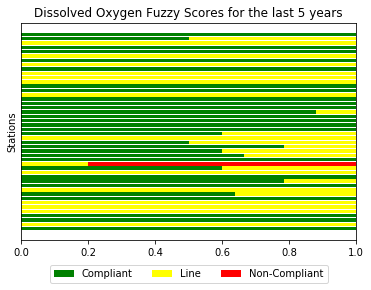

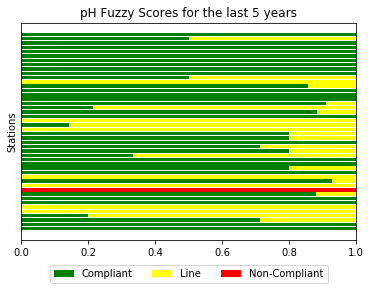

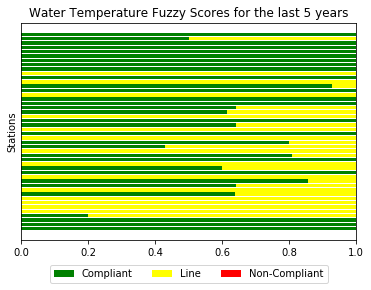

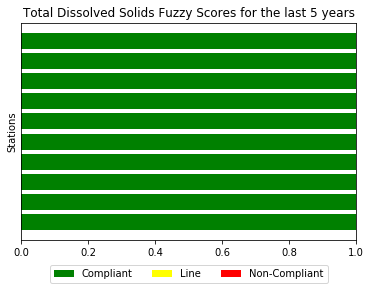

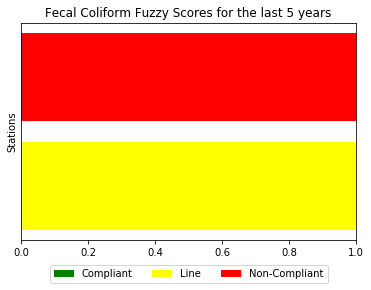

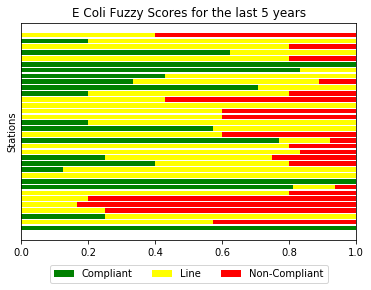

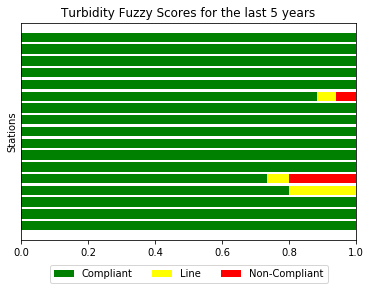

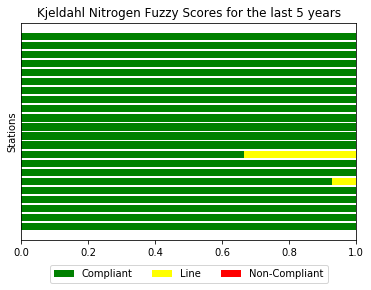

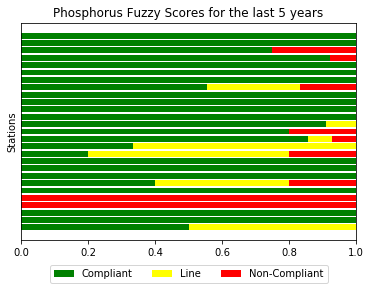

<Figure size 432x288 with 0 Axes>

In [11]:
num_years = 5
#metric = metrics[3]

for metric in metrics:

    metric_temp_df = pd.read_csv(os.path.join(output_directory, 'Fuzzy_Score_Export_{}.csv'.format(metric)))
    metric_temp_df['ActivityStartDate'] = pd.to_datetime(metric_temp_df['ActivityStartDate'])    
    metric_temp_df['ActivityStartDate_Clean'] = metric_temp_df.apply(clean_date, axis=1)
    year_desired = datetime.datetime(datetime.datetime.now().year - num_years, 1, 1)
    recent_df = metric_temp_df[metric_temp_df['ActivityStartDate_Clean'] > year_desired]
    #recent_df = metric_temp_df.loc[metric_temp_df.groupby('MonitoringLocationIdentifier').ActivityStartDate_Clean.idxmax()]
    bar_df = pd.DataFrame()

    for station in recent_df['MonitoringLocationIdentifier'].unique():
        compliant_count = len(recent_df[(recent_df['MonitoringLocationIdentifier'] == station) & (recent_df['Fuzzy Score'] == 1)])
        noncompliant_count = len(recent_df[(recent_df['MonitoringLocationIdentifier'] == station) & (recent_df['Fuzzy Score'] == 0)])
        btwn_count = len(recent_df[recent_df['MonitoringLocationIdentifier'] == station]) - (compliant_count + noncompliant_count)
        temp_df = pd.DataFrame(columns=['Station', 'comp', 'non_comp', 'btwn'], data=[[station, compliant_count, noncompliant_count, btwn_count]])
        bar_df = bar_df.append(temp_df)

    bar_df['Sum'] = bar_df['comp'] + bar_df['non_comp'] + bar_df['btwn']

    bar_df['comp_per'] = bar_df['comp']/bar_df['Sum']
    bar_df['noncomp_per'] = bar_df['non_comp']/bar_df['Sum']
    bar_df['btwn_per'] = bar_df['btwn']/bar_df['Sum']

    bars = np.add(bar_df['comp_per'], bar_df['btwn_per'])
    #bar_df = bar_df[50:60]
    plt.barh(bar_df['Station'], bar_df['comp_per'], color='green')
    plt.barh(bar_df['Station'], bar_df['btwn_per'], left=bar_df['comp_per'], color='yellow')
    plt.barh(bar_df['Station'], bar_df['noncomp_per'], left=bars, color='red')
    plt.legend(['Compliant', 'Line', 'Non-Compliant'], loc='upper center', bbox_to_anchor=(0.5, -0.09), ncol=3)
    plt.title('{} Fuzzy Scores for the last {} years'.format(metric, num_years))
    plt.yticks([],[])
    plt.ylabel('Stations')
    plt.figure()

In [12]:
#%%################################ SCORE METRICS ############################

In [13]:
#%%################################ COMPILE CATEGORIES ############################

In [14]:
#%%################################ GENERATE SCORE ############################

In [15]:
#%%################################ VISUALIZE SCORES ############################